# Develop a Neural Image Caption Generation Model

Caption generation is a challenging artificial intelligence problem where a textual description
must be generated for a given photograph. It requires both methods from computer vision to
understand the content of the image and a language model from the field of natural language
processing to turn the understanding of the image into words in the right order. Recently, deep
learning methods have achieved state-of-the-art results on examples of this problem.
Deep learning methods have demonstrated state-of-the-art results on caption generation
problems. What is most impressive about these methods is a single end-to-end model can be
defined to predict a caption, given a photo, instead of requiring sophisticated data preparation
or a pipeline of specifically designed models. 

In this assignment, you will  develop a photo captioning deep learning model from scratch. You will develop and extend some of the the following tasks (see later sections for task specification):

1.  How to prepare photo and text data for training a deep learning model.
* How to design and train a deep learning caption generation model using unconventional language model.
* How to evaluate a trained caption generation model and use it to caption entirely new photographs.

In neural image captioning systems, a recurrent neural network (RNN) is typically viewed as the primary ‘generation’ component. This view suggests that the image features should be ‘injected’ into the RNN (referred to as the `inject` architecture). This is in fact the dominant view in the literature. Alternatively, the RNN can instead be viewed as only encoding the previously generated words. This view suggests that the RNN should only be used to encode linguistic features and that only the final representation should be ‘merged’ with the image features at a later stage. This is sometimes referred to as the `merge` architecture. In this assignment you will be required to compare these two architectures. A sample merge archtecture, along with typical modeling pipeline is provided to help you boostrap this assignment. You will be required to implement the inject architecture for image captioning. Subsequently you should be able to answer the following question (after finetuning various hyperparameters and architectures): Does late merging outperforms injection, thereby suggesting that RNNs are better viewed as **encoders**, rather than **generators**?

# Flickr8k Photo and Caption Dataset

In this assignment, we will use the Flickr8k dataset. The dataset is available for free. You must complete a request form and the links to the dataset will be emailed to you. I would love to link to them for you, but the email address
expressly requests: Please do not redistribute the dataset. You can use the link below to request the dataset:

* Dataset Request Form.
  *  https://illinois.edu/fb/sec/1713398

Within a short time, you will receive an email that contains links to two files:
* Flickr8k_Dataset.zip (1 Gigabyte) An archive of all photographs.
* Flickr8k_text.zip (2.2 Megabytes) An archive of all text descriptions for photographs.

Download the datasets and unzip them into your current working directory. You will have two directories:
* Flicker8k Dataset: Contains 8092 photographs in JPEG format (yes the directory name spells it `Flicker` not `Flickr`).
* Flickr8k text: Contains a number of files containing different sources of descriptions for the photographs.


The dataset has a pre-defined training dataset (6,000 images), development/validation dataset (1,000 images), and test dataset (1,000 images). One measure that can be used to evaluate the skill of the model are BLEU scores. For reference, below are some ball-park BLEU scores for skillful models when evaluated on the test dataset (taken from the 2017 paper Where to put the Image in an Image Caption Generator)


|Metric|Performance Range|
|:----:|:---------------:|
|BLEU-1| 0.401 to 0.578|
|BLEU-2| 0.176 to 0.390|
|BLEU-3| 0.099 to 0.260|
|BLEU-4| 0.059 to 0.170|

A higher score close to 1.0 is better, a score closer to zero is worse. We describe the BLEU metric more later when we work on evaluating our model. Next, let's
look at how to load the images.



# Metrics: Bilingual Evaluation Understudy (BLEU)
The Bilingual Evaluation Understudy Score, or BLEU for short, is a metric for evaluating a generated sentence to a reference sentence. A perfect match results in a score of 1.0, whereas a
perfect mismatch results in a score of 0.0. The score was developed for evaluating the predictions made by automatic machine translation systems. It is not perfect, but does offer 5 compelling
benefits:

1. It is quick and inexpensive to calculate.
* It is easy to understand.
* It is language independent.
* It correlates highly with human evaluation.
* It has been widely adopted.

The BLEU score was proposed by Kishore Papineni, et al. in their 2002 paper BLEU: a Method for Automatic Evaluation of Machine Translation. The approach works by counting matching n-grams in the candidate translation to n-grams in the reference text, where 1-gram or unigram would be each token and a bigram comparison would be each word pair. The
comparison is made regardless of word order.

> The primary programming task for a BLEU implementor is to compare n-grams of
 the candidate with the n-grams of the reference translation and count the number
of matches. These matches are position-independent. The more the matches, the
better the candidate translation is.  `BLEU: a Method for Automatic Evaluation of Machine Translation, 2002.`

In addition to translation, we can use the BLEU score for other language generation problems
with deep learning methods such as:

* Language generation.
* Image caption generation.
* Text summarization.
* Speech recognition.
* And much more.

For more details on BLEU scores and lots of wonderful examples see [WikiPedia](https://en.wikipedia.org/wiki/BLEU)

## Sentence BLEU Score Example
NLTK provides the sentence `bleu()` function for evaluating a candidate sentence against one
or more reference sentences. The reference sentences must be provided as a list of sentences
where each reference is a list of tokens. The candidate sentence is provided as a list of tokens.
For example:

In [28]:
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'is', 'a', 'test'], ['this', 'is' 'test']]
candidate = ['this', 'is', 'a', 'test']
score = sentence_bleu(reference, candidate)
print(score)

1.0


Running this example prints a perfect score of **1.0** as the candidate matches one of the references exactly.

## Corpus BLEU Score (not Sentence)

NLTK also provides a function called `corpus_bleu()` for calculating the BLEU score for multiple
sentences such as a paragraph or a document. The references must be specified as a list of
documents where each document is a list of references and each alternative reference is a list of
tokens, e.g. a list of lists of lists of tokens. The candidate documents must be specified as a list
where each document is a list of tokens, e.g. a list of lists of tokens. This is a little confusing;
here is an example of two references for one document.

In [27]:
# two references for one document
from nltk.translate.bleu_score import corpus_bleu
references = [[['this', 'is', 'a', 'test'], ['this', 'is' 'test']]]
candidates = [['this', 'is', 'a', 'test']]
score = corpus_bleu(references, candidates)
print(score)

1.0


# Generate training examples from Image-Caption pairs
The section describes how to prepare the photo and text pairs  for training a deep image captioning model. Each channel will be preprocessed separately and will act an separate inputs to the multimodal network. 


## Prepare Photo Data using VGGNet

We will use a pre-trained model to interpret the content of the photos. There are many models
to choose from. In this case, we will use the Oxford Visual Geometry Group, or VGG, model
that won the ImageNet competition in 2014. Keras provides this pre-trained model directly.
Note, the first time you use this model, Keras will download the model weights from the Internet,
which are about 500 Megabytes. This may take a few minutes depending on your internet
connection. Note the use of the VGG pre-trained model is an example of **transfer learning**.

We could use this model as part of a broader image caption model. The problem is, it
is a large model and running each photo through the network every time we want to test a
new language model configuration (downstream) is redundant. Instead, we can pre-compute
the photo features using the pre-trained model and save them to file. We can then load these
features later and feed them into our model as the interpretation of a given photo in the dataset.
It is no different to running the photo through the full VGG model; it is just we will have done
it once in advance.

This is an optimization that will make training our models faster and consume less memory.
We can load the VGG model in Keras using the VGG class. We will remove the last layer from
the loaded model, as this is the model used to predict a classification for a photo. We are not
interested in classifying images, but we are interested in the internal representation of the photo
right before a classification is made. These are the features that the model has extracted from
the photo.

Keras also provides tools for reshaping the loaded photo into the preferred size for the model
(e.g. 3 channel 224 x 224 pixel image). Below is a function named `extract_features()` that,
given a directory name, will load each photo, prepare it for VGG, and collect the predicted
features from the VGG model. The image features are a 1-dimensional 4,096 element vector.
The function returns a dictionary of image identifier to image features.


We can call this function to prepare the photo data for testing our models, then save the
resulting dictionary to a file named features.pkl. The complete example is listed below.

Running this data preparation step may take a while depending on your hardware, perhaps
one hour on the CPU with a modern workstation. At the end of the run, you will have
the extracted features stored in features.pkl for later use. This file will be a few hundred
Megabytes in size.

In [3]:
#Make sure data is avialble locally
!ls

Captioning.ipynb  Flicker8k_Dataset Flickr8k_text     example.jpg


In [4]:
!ls -l Flickr8k_text/

total 19784
-rw-r--r--@ 1 tsv02  staff  2918552 Oct 14  2013 CrowdFlowerAnnotations.txt
-rw-r--r--@ 1 tsv02  staff   346674 Oct 14  2013 ExpertAnnotations.txt
-rw-r--r--@ 1 tsv02  staff  3244761 Feb 15  2012 Flickr8k.lemma.token.txt
-rw-r--r--@ 1 tsv02  staff  3395237 Oct 14  2013 Flickr8k.token.txt
-rw-r--r--@ 1 tsv02  staff    25801 Oct 10  2013 Flickr_8k.devImages.txt
-rw-r--r--@ 1 tsv02  staff    25775 Oct 10  2013 Flickr_8k.testImages.txt
-rw-r--r--@ 1 tsv02  staff   154678 Oct 10  2013 Flickr_8k.trainImages.txt
-rw-r--r--@ 1 tsv02  staff     1821 Oct 14  2013 readme.txt


In [5]:
from os import listdir
from os import path
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

# extract features from each photo in the directory
def extract_features(directory):
    # load the model
    model = VGG16()
    # re-structure the model; use all layers except the last softmax layer corresponding 
    # to the 1000 classes for ImageNet
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    # summarize
    model.summary()
    # extract features from each photo
    features = dict()
    for name in listdir(directory):
        # load an image from file
        filename = path.join(directory, name)
        image = load_img(filename, target_size=(224, 224))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the VGG model
        image = preprocess_input(image)
        # get features
        feature = model.predict(image, verbose=0)
        # get image id
        image_id = name.split('.')[0]
        # store feature
        features[image_id] = feature
        print('>%s' % name)
    return features

# extract features from all images
directory = 'Flicker8k_Dataset'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('features.pkl', 'wb'))

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

>1229756013_94663527d7.jpg
>1231229740_8dcbf80bfb.jpg
>1232148178_4f45cc3284.jpg
>1234293791_6566284bcd.jpg
>1234817607_924893f6e1.jpg
>1235580648_7eebaed9bc.jpg
>1235681222_819231767a.jpg
>1235685934_be89b231fb.jpg
>1236951314_0308dc4138.jpg
>1236964638_1808784a3c.jpg
>1237985362_dbafc59280.jpg
>123889082_d3751e0350.jpg
>123997871_6a9ca987b1.jpg
>1240297429_c36ae0c58f.jpg
>124195430_d14028660f.jpg
>1244140539_da4804d828.jpg
>1244306891_8e78ae1620.jpg
>1244485675_822e6efe60.jpg
>1245022983_fb329886dd.jpg
>1247181182_35cabd76f3.jpg
>1248357227_2b4175fc39.jpg
>1248734482_3038218f3b.jpg
>124881487_36e668145d.jpg
>1248940539_46d33ed487.jpg
>1248953128_24c9f8d924.jpg
>124972799_de706b6d0b.jpg
>1251558317_4ef844b775.jpg
>1252396628_eb81d3905b.jpg
>1252787177_4b08625897.jpg
>125319704_49ead3463c.jpg
>1253264731_e7c689eca5.jpg
>1253275679_e955fb7304.jpg
>1255504166_f2437febcb.jpg
>1258913059_07c613f7ff.jpg
>1259936608_e3f0064f23.jpg
>1260816604_570fc35836.jpg
>1262077938_8b9516c273.jpg
>126245

>1460500597_866fa0c6f3.jpg
>146098876_0d99d7fb98.jpg
>146100443_906d87faa2.jpg
>1461329041_c623b06e5b.jpg
>1461653394_8ab96aae63.jpg
>1461667284_041c8a2475.jpg
>1463638541_c02cfa04dc.jpg
>1463732130_a754441289.jpg
>1463732807_0cdf4f22c7.jpg
>1464120327_d90279ca3a.jpg
>1465666502_de289b3b9c.jpg
>146577645_91b570c0d0.jpg
>146577646_9e64b8c2dc.jpg
>1466307485_5e6743332e.jpg
>1466307489_cb8a74de09.jpg
>1466479163_439db855af.jpg
>1467533293_a2656cc000.jpg
>1468103286_96a6e07029.jpg
>1468389504_c724bdcad0.jpg
>1468429623_f001988691.jpg
>1468962616_5803b4397f.jpg
>1469000260_5d473c8283.jpg
>1469358746_2a879abaf3.jpg
>1470061031_4cb59c12a8.jpg
>1470132731_fa416b7504.jpg
>1470536919_1f3fd6c65a.jpg
>1472053993_bed67a3ba7.jpg
>1472230829_803818a383.jpg
>1472249944_d887c3aeda.jpg
>1472653060_7427d2865a.jpg
>1472882567_33dc14c8b6.jpg
>1473080948_bae2925dc8.jpg
>1473250020_dc829a090f.jpg
>1473618073_7db56a5237.jpg
>1474474514_b3eb492722.jpg
>1475046848_831245fc64.jpg
>1476002408_4256b7b2fa.jpg
>1476

>1937104503_313d22a2d0.jpg
>1937262236_cbf5bfa101.jpg
>1947351225_288d788983.jpg
>195084264_72fb347b0f.jpg
>1952896009_cee8147c90.jpg
>1956678973_223cb1b847.jpg
>1956944011_c5661d3f22.jpg
>1957371533_62bc720bac.jpg
>195962284_e57178054a.jpg
>195962790_3380aea352.jpg
>1962729184_6996e128e7.jpg
>1965278563_8279e408de.jpg
>1969573381_5ecfae4c80.jpg
>197107117_4b438b1872.jpg
>197142902_f05ff198c2.jpg
>197504190_fd1fc3d4b7.jpg
>1975171469_84e425f61b.jpg
>1975531316_8b00eeaaf7.jpg
>1977827746_4e13d7e19f.jpg
>197924859_f6e39a7dfa.jpg
>1980315248_82dbc34676.jpg
>1980882959_9a161f3469.jpg
>1982852140_56425fa7a2.jpg
>1984936420_3f3102132b.jpg
>1989145280_3b54452188.jpg
>1991806812_065f747689.jpg
>1994416869_4dd769a806.jpg
>199463720_329a802206.jpg
>199809190_e3f6bbe2bc.jpg
>1998255400_0cd086908f.jpg
>1998457059_c9ac9a1e1a.jpg
>1999444757_1b92efb590.jpg
>2000459828_3c9e109106.jpg
>2003663004_5b70920a98.jpg
>2004674713_2883e63c67.jpg
>200771289_31902164a7.jpg
>2009636597_e3f4fe19fb.jpg
>201682811_

>2156131463_5b53636cf0.jpg
>2156726763_034ecd2e39.jpg
>2157003092_eaeb977789.jpg
>2157173498_2eea42ee38.jpg
>2158247955_484f0a1f11.jpg
>2158267555_db1d94e468.jpg
>215876547_fa584c5ec3.jpg
>2159447283_fab8c272b0.jpg
>2160266952_a2ab39191b.jpg
>216172386_9ac5356dae.jpg
>2161799386_27aa938421.jpg
>2162469360_ff777edc95.jpg
>2162564553_96de62c7e6.jpg
>2164363131_6930455d45.jpg
>2165459064_5b81ff23eb.jpg
>2165461920_1a4144eb2b.jpg
>2165677531_e1d5e086f7.jpg
>2167644298_100ca79f54.jpg
>2169067981_cc19268f23.jpg
>2169951750_495820a215.jpg
>2170187328_65c2f11891.jpg
>2170222061_e8bce4a32d.jpg
>2171154778_8189169336.jpg
>2171576939_d1e72daab2.jpg
>2171891283_dedd9cf416.jpg
>2172493537_128bc8b187.jpg
>2172526745_649f420569.jpg
>2173061319_1f267765dc.jpg
>2173312932_269f9786fc.jpg
>2173677067_9d0732bcc2.jpg
>2174206711_11cb712a8d.jpg
>217583047_5e93e1e119.jpg
>2176147758_9a8deba576.jpg
>2176364472_31fcd37531.jpg
>2176874361_2b4149010b.jpg
>2176980976_7054c99621.jpg
>2178064851_bb39652d28.jpg
>217

>2276120079_4f235470bc.jpg
>2276314067_7ee246f859.jpg
>2276499757_b44dc6f8ce.jpg
>2277081067_d2b4c98bce.jpg
>2277299634_e14bdb7ff7.jpg
>2278110011_ba846e7795.jpg
>2278766574_f71f1704a8.jpg
>2278776373_fe499a93be.jpg
>2279496715_8ef3ee6edb.jpg
>2279945145_8815c59217.jpg
>2279980395_989d48ae72.jpg
>2280354512_c0d035d53f.jpg
>2280525192_81911f2b00.jpg
>2281006675_fde04e93dd.jpg
>2281054343_95d6d3b882.jpg
>2281075738_230892b241.jpg
>2281768510_9cc5728c55.jpg
>2282043629_91b7831352.jpg
>2282260240_55387258de.jpg
>2282522980_45cfa8e0cf.jpg
>2282600972_c22d1e03c7.jpg
>2282895743_f803f1cf01.jpg
>2283966256_70317e1759.jpg
>2284239186_c827f4defa.jpg
>2284894733_b710b9b106.jpg
>2285152690_3fb93f65f1.jpg
>2285570521_05015cbf4b.jpg
>2285741931_07159a21f2.jpg
>2286032269_8ba929709c.jpg
>2286235203_af3cd8f243.jpg
>2286236765_2a63eeb550.jpg
>2286239223_d84ffc4e4a.jpg
>2286270205_16038dec5a.jpg
>2286823363_7d554ea740.jpg
>2287023569_fd7a9c60b8.jpg
>2287887341_663bfa15af.jpg
>2288099178_41091aa00c.jpg
>

>2394857899_76bfdf720b.jpg
>2394919002_ed7527ff93.jpg
>2394922193_310166d6af.jpg
>2395967330_7e6ea404f6.jpg
>2396025708_e4a72e2558.jpg
>2396100671_3a9d67f03d.jpg
>2396669903_5217a83641.jpg
>2396691909_6b8c2f7c44.jpg
>2396746868_0727e06983.jpg
>239807547_4923efc821.jpg
>2398605966_1d0c9e6a20.jpg
>2399114095_c3196ff456.jpg
>2399219552_bbba0a9a59.jpg
>2399551242_c62a46dd5f.jpg
>2400958566_4e09424046.jpg
>2402462857_7684848704.jpg
>2402744031_11f9f2f2b8.jpg
>2402793046_3385554e81.jpg
>2403078014_4b1d6f8bde.jpg
>2403376030_903521c371.jpg
>2403544744_cba152f5c1.jpg
>2404488732_ca1bbdacc2.jpg
>2404520067_87798dbaee.jpg
>2404692474_37da774368.jpg
>2405599120_ec5f32af6f.jpg
>240583223_e26e17ee96.jpg
>2405978603_6221b0c2e7.jpg
>2406591500_403f145905.jpg
>240696675_7d05193aa0.jpg
>2407091303_931c918490.jpg
>2407470303_6fd5e3600d.jpg
>2409312675_7755a7b816.jpg
>2409597310_958f5d8aff.jpg
>2410040397_1a161a1146.jpg
>2410153942_ba4a136358.jpg
>241031254_0c6f30e3d1.jpg
>241031670_e60f59b8e4.jpg
>24103

>2474092890_6c0781a8ed.jpg
>2474918824_88660c7757.jpg
>2475162978_2c51048dca.jpg
>2475300106_b8563111ba.jpg
>247617035_9f2e821534.jpg
>247617754_4b1137de8c.jpg
>247618600_239eeac405.jpg
>247619370_a01fb21dd3.jpg
>2476214153_99a3998509.jpg
>247637795_fdf26a03cf.jpg
>247652942_29ede19352.jpg
>247691240_3881777ab8.jpg
>247704641_d883902277.jpg
>247706586_7e25c7adf8.jpg
>2477121456_1ac5c6d3e4.jpg
>2477623312_58e8e8c8af.jpg
>247778426_fd59734130.jpg
>2478929971_9eb6c074b6.jpg
>2479162876_a5ce3306af.jpg
>2479180530_7ebba2d8bf.jpg
>2479553749_f7ac031940.jpg
>2479652566_8f9fac8af5.jpg
>2480021389_dda9fb2818.jpg
>2480327661_fb69829f57.jpg
>2480664591_e6d22ed61c.jpg
>2480668859_6f9b46be6a.jpg
>2480820830_bdec1f5b76.jpg
>2480832276_fa55480ecb.jpg
>2480850054_de3433b54a.jpg
>2481003841_06086eafc2.jpg
>2481367956_8577d2fa98.jpg
>2481490320_7978c76271.jpg
>2481598514_05a65d1f72.jpg
>248174959_2522871152.jpg
>2482629385_f370b290d1.jpg
>2483792149_a9b4ffecec.jpg
>2483993772_f64e9e4724.jpg
>2483993827_

>2579266054_1ec58aa92f.jpg
>2579268572_d78f8436cb.jpg
>2579460386_94c489028d.jpg
>2579572274_826598b14a.jpg
>2579899436_5086a33c7a.jpg
>2580215443_4e64afe3d5.jpg
>2581066814_179d28f306.jpg
>2582390123_71120edb0c.jpg
>2583001715_1ce6f58942.jpg
>2584020755_14e2b3e8fc.jpg
>2584412512_6767593f24.jpg
>2584487952_f70e5aa9bf.jpg
>258476074_f28f4a1ae6.jpg
>2584957647_4f9235c150.jpg
>2585141045_b496a7b7c4.jpg
>2586028627_ddd054d8cc.jpg
>2586532797_dcf22a5021.jpg
>2586911841_41b7a48c91.jpg
>2587017287_888c811b5a.jpg
>2587106431_1cc0e719c6.jpg
>2587696611_db0378710f.jpg
>2587818583_4aa8e7b174.jpg
>2587846523_b177c9a3e3.jpg
>2588456052_8842b47005.jpg
>2588625139_fdf6610218.jpg
>2588927489_f4da2f11ec.jpg
>2589156742_c46bc82137.jpg
>2589241160_3832440850.jpg
>2589308405_e208b5e745.jpg
>2590207488_ddd89037ba.jpg
>2591110592_ef5f54f91c.jpg
>2591455200_2319651f2f.jpg
>2591486448_48d5438343.jpg
>2591603141_33d6397e0a.jpg
>2592019072_a6c0090da4.jpg
>2592711202_55f8c64495.jpg
>259314892_a42b8af664.jpg
>25

>2680619645_ab6645218d.jpg
>2680990587_eee6bd04fb.jpg
>2681215810_00b0642f7b.jpg
>2682194299_92005b26c6.jpg
>2682382530_f9f8fd1e89.jpg
>268365231_a0acecdc45.jpg
>2683963310_20dcd5e566.jpg
>2683985894_167d267dcb.jpg
>2684322797_85406f571d.jpg
>2684323357_c7a6d05d05.jpg
>2684489465_32ba1d0344.jpg
>2685139184_4ff45e0f76.jpg
>2685752892_9d5cd7f274.jpg
>2685788323_ceab14534a.jpg
>2686432878_0697dbc048.jpg
>268654674_d29e00b3d0.jpg
>268704620_8a8cef4cb3.jpg
>2687229880_97cfd8148e.jpg
>2687328779_b4356dab16.jpg
>2687529141_edee32649e.jpg
>2687539673_d54a8dc613.jpg
>2687672606_275169c35d.jpg
>2688102742_885e578a3f.jpg
>2688902319_52ceaf4a2a.jpg
>2689001252_e0016c89f0.jpg
>2689163361_4939875be5.jpg
>2689358407_9932f1b20c.jpg
>2689491604_d8760f57b4.jpg
>2690538407_7ca157be85.jpg
>2690702549_cf81da8cf6.jpg
>2691966747_cfa154982b.jpg
>2692635048_16c279ff9e.jpg
>2693425189_47740c22ed.jpg
>2693539377_5442430f81.jpg
>269361490_a22ae818bf.jpg
>2694178830_116be6a6a9.jpg
>2694426634_118566f7ab.jpg
>2694

>2785115802_137fa30000.jpg
>278559394_b23af734b9.jpg
>278608022_4175813019.jpg
>2786245676_0a69543832.jpg
>2786299623_a3c48bd318.jpg
>2787276494_82703f570a.jpg
>2787868417_810985234d.jpg
>2788628994_61123c03d2.jpg
>2788652511_4f10060e07.jpg
>2788945468_74a9618cfa.jpg
>2789238858_14261dd25a.jpg
>2789350645_96a2535b4d.jpg
>2789648482_1df61f224a.jpg
>2789688929_9424fceed1.jpg
>2789937754_5d1fa62e95.jpg
>2790909995_8b7a03d9d1.jpg
>2792195540_af5fb95caa.jpg
>2792212974_23b1ef05fa.jpg
>279230262_e541f9b670.jpg
>2792409624_2731b1072c.jpg
>2795287622_da187a3e86.jpg
>2795352290_9209b214f3.jpg
>279550225_d64d56158a.jpg
>2795866891_7559fd8422.jpg
>2796801478_8ebd7e550b.jpg
>2797149878_bb8e27ecf9.jpg
>2797185895_4d9e1e9508.jpg
>2797188545_aeb26c54c0.jpg
>279728508_6bd7281f3c.jpg
>2797438951_88a3ed7541.jpg
>2797511323_bf20acab45.jpg
>2798651021_2566f2a47e.jpg
>2798880731_4f51634374.jpg
>279901198_e7a88c855a.jpg
>2799871904_3b3125518a.jpg
>2800004913_c8394ba332.jpg
>2800758232_d7fa598065.jpg
>280093

>2882483779_73c171ac19.jpg
>2882589788_cb0b407a8d.jpg
>2882743431_c3e6cd1b5c.jpg
>2882893687_1d10d68f2b.jpg
>2883099128_0b056eed9e.jpg
>2883324329_24361e2d49.jpg
>2883907436_82bf4a36b8.jpg
>2883950737_3b67d24af4.jpg
>2884092603_786b53a74b.jpg
>2884252132_5d8e776893.jpg
>2884301336_dc8e974431.jpg
>2884400562_e0851014fc.jpg
>2884420269_225d27f242.jpg
>2884651479_12e400ee58.jpg
>288508162_1727873924.jpg
>2885111681_dc328ecfff.jpg
>2885382946_f541ea5722.jpg
>2885387575_9127ea10f1.jpg
>2885891981_6b02620ae9.jpg
>2885912662_a3a2dfde45.jpg
>2886411666_72d8b12ce4.jpg
>2886533440_dfa832f2fa.jpg
>2886837407_a4510ab1ef.jpg
>2887103049_a867e74358.jpg
>2887171449_f54a2b9f39.jpg
>2887614578_ed7ba21775.jpg
>2887744223_029f2fd5fe.jpg
>2887750774_920eb171aa.jpg
>2887798667_ce761d45e8.jpg
>2888386138_578d21033a.jpg
>2888408966_376c195b3f.jpg
>2888658480_e922a3dec2.jpg
>2888702775_0939a6680e.jpg
>2888732432_7e907a3df1.jpg
>288880576_818b6ecfef.jpg
>2890057168_c712f932e0.jpg
>2890075175_4bd32b201a.jpg
>28

>2970183443_accd597e0a.jpg
>2970461648_fe14ba0359.jpg
>2971211296_2587c3924d.jpg
>2971298546_dd595cf297.jpg
>2971431335_e192613db4.jpg
>2971478694_79e46ea7e5.jpg
>297169473_d3974e0275.jpg
>297285273_688e44c014.jpg
>2972864304_481aeffe50.jpg
>2972929655_04233b5489.jpg
>2973269132_252bfd0160.jpg
>2973272684_4d63cbc241.jpg
>2973638173_0dc21fd443.jpg
>2974501005_346f74e5d8.jpg
>2974587819_742fb7c338.jpg
>2975018306_0e8da316f5.jpg
>2975073156_7543ed326f.jpg
>2975118353_5af5a5df54.jpg
>2975253472_0f0c2dea70.jpg
>2975807155_5a8610c297.jpg
>2976155358_b4dd4407cf.jpg
>2976350388_3984e3193d.jpg
>2976537455_f3988c2d46.jpg
>2976684095_ce7ccfd423.jpg
>2976946039_fb9147908d.jpg
>297724467_e8918a6f90.jpg
>2977246776_b14be8290d.jpg
>2977379863_2e8d7a104e.jpg
>2978024878_a45b282bf4.jpg
>2978236380_fb24c43f1e.jpg
>2978271431_f6a7f19825.jpg
>2978394277_4572967b97.jpg
>2978409165_acc4f29a40.jpg
>2978735290_7464b12270.jpg
>2978810122_183e60ff2d.jpg
>2979914158_5906470b8f.jpg
>2980118787_2099de53ec.jpg
>298

>3052104757_d1cf646935.jpg
>3052196390_c59dd24ca8.jpg
>3053415073_5b667230ed.jpg
>3053743109_a2d780c0d2.jpg
>3053785363_50392f2c53.jpg
>3053813297_7ce5f87710.jpg
>3053916979_848d32261b.jpg
>3054200086_657d4398e8.jpg
>3054989420_3e755ca352.jpg
>3054997030_797096dd12.jpg
>3055716848_b253324afc.jpg
>3056530884_27766059bc.jpg
>3056569684_c264c88d00.jpg
>3057497487_57ecc60ff1.jpg
>305749904_54a612fd1a.jpg
>3057618932_3b80ae85de.jpg
>3057770908_3fd97f79f9.jpg
>3057862887_135c61816a.jpg
>3058439373_9276a4702a.jpg
>3058627443_1d57ff0a2c.jpg
>3060519665_4d6b9a51b2.jpg
>3060594966_030658d318.jpg
>3060969260_08f43e4f4f.jpg
>3061481868_d1e00b1f2e.jpg
>3062173277_bfb5ef4c45.jpg
>3062273350_fd66106f21.jpg
>306315650_e064f5c677.jpg
>306318683_5f1f875191.jpg
>3063544435_10516c6937.jpg
>3064097919_e536ab9693.jpg
>3064383768_f6838f57da.jpg
>3064716525_b8418d4946.jpg
>3065468339_4955e90fd3.jpg
>3065560742_f6e266ccd9.jpg
>3066338314_2c3fb731d1.jpg
>3066429707_842e50b8f7.jpg
>3066491113_86569e15be.jpg
>306

>3131160589_dc73c209b7.jpg
>3131632154_098f86f4cb.jpg
>3131990048_369b081021.jpg
>3132006797_04822b5866.jpg
>3132619510_7dfc947d25.jpg
>3132760860_3e743a935d.jpg
>3132832452_c354c6396c.jpg
>3132903412_b4780d0ccf.jpg
>3133044777_8cc930a4ec.jpg
>313326614_b2adbe59e0.jpg
>3133403457_95dfe11da1.jpg
>3133825703_359a0c414d.jpg
>3134092148_151154139a.jpg
>3134341610_3c55e373a7.jpg
>3134385454_4f1d55333f.jpg
>3134387321_3a253224c1.jpg
>3134387513_ceb75bea0a.jpg
>3134585858_a8c3493ca5.jpg
>3134586018_ae03ba20a0.jpg
>3134644844_493eec6cdc.jpg
>3135504530_0f4130d8f8.jpg
>3135826945_f7c741e5b7.jpg
>3136043366_b3f8607a0e.jpg
>3136404885_f4d8f1d15a.jpg
>3136674757_57406c305c.jpg
>3136688093_568b053bdf.jpg
>3137061312_eb5fdcf3fd.jpg
>3138399980_d6ab8b2272.jpg
>3138433655_ea1d59e5b7.jpg
>3138504165_c7ae396294.jpg
>3138562460_44227a35cf.jpg
>3138746531_f6b816c126.jpg
>3139118874_599b30b116.jpg
>3139160252_75109e9e05.jpg
>3139238055_2817a0c7d8.jpg
>3139389284_f01bd4c236.jpg
>3139393607_f0a54ca46d.jpg
>3

>3199895624_4f01798c6f.jpg
>3200120942_59cfbb3437.jpg
>320093980_5388cb3733.jpg
>3201427741_3033f5b625.jpg
>3201594926_cd2009eb13.jpg
>3201666946_04fe837aff.jpg
>3202255152_08973fa3d7.jpg
>3202360797_2084743e90.jpg
>3203453897_6317aac6ff.jpg
>3203707977_cc9448fecb.jpg
>3203742047_6a55065411.jpg
>3203872773_6c30f64be3.jpg
>3203878596_cbb307ce3b.jpg
>3203908917_53e53c03d1.jpg
>3204081508_0e7f408097.jpg
>3204354161_caf89ec784.jpg
>3204525212_d548c7fca7.jpg
>3204686006_88f04547b9.jpg
>3204712107_5a06a81002.jpg
>3204922011_185e48949a.jpg
>3205214191_29b42b9b09.jpg
>3205336477_037d4b6bd9.jpg
>3205754736_32c29b5208.jpg
>3205839744_24504ba179.jpg
>3206058778_7053ee6b52.jpg
>3206919175_e3a11b6874.jpg
>3206999917_e682672cbc.jpg
>3207264553_8cd4dcde53.jpg
>3207343907_995f7ac1d2.jpg
>3207358897_bfa61fa3c6.jpg
>3207654194_43d6bebd68.jpg
>3207676216_48478bce97.jpg
>3207775692_bb897d9afd.jpg
>3208032657_27b9d6c4f3.jpg
>3208074567_ac44aeb3f3.jpg
>3208188198_2b271d2a2e.jpg
>3208553539_2bf6c6d162.jpg
>3

>3259229498_2b5708c0c6.jpg
>3259231890_16fe167b31.jpg
>3259579174_30a8a27058.jpg
>3259666643_ae49524c81.jpg
>3259694057_fae7484b0a.jpg
>3259757648_71edb4347b.jpg
>3259883609_6a1b46919e.jpg
>3259991972_fce3ab18b2.jpg
>3259992164_94600858b3.jpg
>3259992638_0612a40288.jpg
>3259992722_4c5e895734.jpg
>3260088697_af9b6d2393.jpg
>3260191163_6c1551eee8.jpg
>3260214530_7179346407.jpg
>326028454_fb396167e6.jpg
>3260768565_2b725be090.jpg
>3260975858_75d0612a69.jpg
>3261493263_381a4c5cc7.jpg
>3261666285_86fceb762d.jpg
>3262075846_5695021d84.jpg
>3262301835_9f1a49b80a.jpg
>3262386960_14f5d857db.jpg
>3262475923_f1f77fcd9f.jpg
>3262647146_a53770a21d.jpg
>3262760716_1e9734f5ba.jpg
>3262793378_773b21ec19.jpg
>3262849619_0bc4f88ef9.jpg
>3263141261_db3a4798b5.jpg
>3263215700_e27f81f8b9.jpg
>326334188_8850b7bfd4.jpg
>3263395801_5e4cee2b9e.jpg
>3263497678_8bb688ca01.jpg
>3263741906_6e4508d1c8.jpg
>3263946591_a1558b77d3.jpg
>3264337159_e1680a35ba.jpg
>3264350290_f50494e835.jpg
>3264397357_72f084cac1.jpg
>32

>3326086533_23a0a54a8e.jpg
>3326204251_2f9e446a2f.jpg
>3326249355_e7a7c71f06.jpg
>3326273086_e09e845185.jpg
>3326376344_3306bf439e.jpg
>3326454455_960e5442e9.jpg
>3326588088_172d1b2584.jpg
>3327487011_1372c425fb.jpg
>3327563443_870a33f748.jpg
>3328247381_a9f7fb4898.jpg
>3328397409_092de2bd32.jpg
>3328495660_ed0e3f29cf.jpg
>3328535573_33c3cd5b59.jpg
>3328646934_5cca4cebce.jpg
>3329169877_175cb16845.jpg
>3329254388_27017bab30.jpg
>3329289652_e09b80e2f3.jpg
>3329777647_5e1fd503ac.jpg
>3329793486_afc16663cc.jpg
>3329858093_0ec73f2190.jpg
>3330007895_78303e8a40.jpg
>3330019493_fd36fbc2ea.jpg
>3330102093_1d6e35e78d.jpg
>333031366_a0828c540d.jpg
>3330333217_1a69497a74.jpg
>3330654550_3efe9a71af.jpg
>3330675488_8692476a4a.jpg
>3330680118_4e541889c1.jpg
>3330935489_9cb67ca36b.jpg
>3331009729_d3b14738e6.jpg
>3331102049_bc65cf6198.jpg
>3331190056_09f4ca9fd2.jpg
>3331525712_af1dcc47f2.jpg
>3331797838_b3e33dbe17.jpg
>3331900249_5872e90b25.jpg
>3332136681_9aecf101fd.jpg
>3332202255_a30c522664.jpg
>3

>3383037991_8f07784b81.jpg
>3383388869_a14552e551.jpg
>3383491811_fd9d3a891d.jpg
>3383545083_1d7c95b003.jpg
>3384314832_dffc944152.jpg
>3384528359_e920154177.jpg
>3384742888_85230c34d5.jpg
>3385246141_a263d1053e.jpg
>3385593926_d3e9c21170.jpg
>3385956569_a849218e34.jpg
>3386060324_b98fdfa449.jpg
>3386375153_20c56d0aae.jpg
>3386893620_5f0bb4e794.jpg
>3386953179_84c2d7922f.jpg
>3387542157_81bfd00072.jpg
>3387630781_f421a94d9d.jpg
>3387661249_33e5ba0bc5.jpg
>3388094307_5a83be64a5.jpg
>3388330419_85d72f7cda.jpg
>3388836914_c267cf3a59.jpg
>3389321512_b11f499dab.jpg
>3389448506_7025e7cc12.jpg
>3391209042_d2de8a8978.jpg
>3391924827_53b31542ce.jpg
>3392019836_c7aeebca1c.jpg
>3392293702_ccb0599857.jpg
>3392851587_a638ff25e2.jpg
>3393035454_2d2370ffd4.jpg
>3393152604_27bd1037f2.jpg
>3393343330_b13df4d8ec.jpg
>3393394134_0caac47e1c.jpg
>3393446245_37dd3f3b59.jpg
>339350939_6643bfb270.jpg
>3393926562_66cc01b001.jpg
>3394070357_cb2a3243fc.jpg
>3394586927_eae7732b64.jpg
>3394654132_9a8659605c.jpg
>3

>3443030942_f409586258.jpg
>3443161359_65544fd732.jpg
>3443326696_fe0549c5be.jpg
>3443351431_7b4061df5c.jpg
>3443460885_46115463b4.jpg
>3443703471_14845d8850.jpg
>3443853670_6c79fcfcb2.jpg
>3444684583_6656e38088.jpg
>3444974984_963fb441a0.jpg
>3444982197_0ff15cc50b.jpg
>3445296377_1e5082b44b.jpg
>3445428367_25bafffe75.jpg
>3445544288_68fdb25969.jpg
>3446191973_1db572ed8a.jpg
>3446347599_0ecc49a9d5.jpg
>3446586125_cafa0bfd67.jpg
>3446762868_06e9d9d899.jpg
>3447007090_08d997833a.jpg
>3447155358_5b5b59b15e.jpg
>3447876218_4ccf42d7a0.jpg
>344841963_8b0fa9784c.jpg
>3448490813_f9623e864d.jpg
>3448855727_f16dea7b03.jpg
>3449114979_6cdc3e8da8.jpg
>3449170348_34dac4a380.jpg
>3449718979_e987c64e2d.jpg
>3449846784_278bc1ba92.jpg
>3450776690_38605c667d.jpg
>3450874870_c4dcf58fb3.jpg
>3451085951_e66f7f5d5c.jpg
>3451344589_6787bd06ef.jpg
>3451345621_fe470d4cf8.jpg
>3451523035_b61d79f6a8.jpg
>3451984463_37ac1ff7a8.jpg
>3452127051_fa54a902b3.jpg
>3452341579_0147d2199b.jpg
>3452411712_5b42d2a1b5.jpg
>3

>3504275465_604ce2ef34.jpg
>350443876_c9769f5734.jpg
>3504479370_ff2d89a043.jpg
>3504881781_6a842e043b.jpg
>3504940491_94c43792ed.jpg
>350529848_9569a3bcbc.jpg
>3505657604_8899161734.jpg
>350588129_6aef7b7fe2.jpg
>3506096155_13632955e8.jpg
>3506216254_04d119cac7.jpg
>3506468593_7e41a6d9f1.jpg
>3506560025_8d0f4f9ac4.jpg
>3506607642_40037b3fbf.jpg
>3506869953_802f463178.jpg
>3507076266_8b17993fbb.jpg
>3507670136_2e5f94accf.jpg
>3508051251_82422717b3.jpg
>3508522093_51f6d77f45.jpg
>3508637029_89f3bdd3a2.jpg
>3508882611_3947c0dbf5.jpg
>3509575615_653cbf01fc.jpg
>3509611207_7645b1d28d.jpg
>3510218982_318f738b76.jpg
>3510219078_670b6b3157.jpg
>3510695264_ef460fa6cc.jpg
>3511062827_cd87871c67.jpg
>3511890331_6163612bb9.jpg
>3512033659_7e8a0c2ffa.jpg
>3512033861_a357bb58b6.jpg
>3512127856_18a4c7aace.jpg
>3512791890_eb065b460a.jpg
>3513265399_a32e8cfd18.jpg
>3513362553_5fc5779e20.jpg
>3514019869_7de4ece2a5.jpg
>3514179514_cbc3371b92.jpg
>3514184232_b336414040.jpg
>3514188115_f51932ae5d.jpg
>351

>3562302012_0cbcd01ff9.jpg
>3562470436_6e193643ce.jpg
>3562816250_6e14d436b1.jpg
>3562903245_85071bb5f9.jpg
>3563059800_c073081ce3.jpg
>3563461991_de05537878.jpg
>3563668905_689ed479c5.jpg
>3563673070_71fa0903ed.jpg
>3563871276_c8b2a00df5.jpg
>3563924606_5914392cd8.jpg
>3564007203_df2b8010f1.jpg
>3564148252_aa4cb36a32.jpg
>3564157681_03a13b7112.jpg
>3564312955_716e86c48b.jpg
>3564385317_1bf5094068.jpg
>3564436847_57825db87d.jpg
>3564543247_05cdbc31cf.jpg
>3564738125_10400f69c0.jpg
>3564742915_5f940b95b4.jpg
>3564907603_14ccc655f1.jpg
>3565021218_d2bc1aa644.jpg
>3565598162_56044bc2f7.jpg
>3565654691_22b97d3994.jpg
>3565655045_8eb00b7423.jpg
>3565749152_7924d15b04.jpg
>3566111626_9a35a7b2c0.jpg
>3566225740_375fc15dde.jpg
>3567061016_62768dcce1.jpg
>3567214106_6ece483f8b.jpg
>3567604049_da9e1be4ba.jpg
>3568065409_1c381aa854.jpg
>3568197730_a071d7595b.jpg
>3568219100_dfbffddccd.jpg
>3568225554_73cdb19576.jpg
>3568505408_4e30def669.jpg
>3568605391_54ec367d88.jpg
>3569126684_a68b29a57f.jpg
>

>3626998066_3ae11ee278.jpg
>3627011534_485f667b10.jpg
>3627076769_3b71e73018.jpg
>3627216820_4952bacbcb.jpg
>3627290893_561e176e80.jpg
>3627676364_1dc9294ec5.jpg
>3627679667_0e3de9fc90.jpg
>3628017876_4ac27e687b.jpg
>3628043835_9d9bd595a7.jpg
>3628059004_5c3529b120.jpg
>3628103548_2708abcda2.jpg
>3628698119_5566769777.jpg
>3628994466_a12065d29b.jpg
>3629492654_619d7b67ee.jpg
>3629664676_36bcefe6b7.jpg
>3630102841_b4c3e00b2c.jpg
>3630332976_fdba22c50b.jpg
>3630641436_8f9ac5b9b2.jpg
>3630991662_990f397f7c.jpg
>3631023049_8a85bab19f.jpg
>3631136463_53ff624b82.jpg
>3631344685_ed0f3e091b.jpg
>3631474374_e40764d153.jpg
>3631671718_d712821757.jpg
>3631810528_7233c0f421.jpg
>3631986552_944ea208fc.jpg
>3632047678_f202609e50.jpg
>3632197966_0c5061025f.jpg
>3632225464_612d7b4c0f.jpg
>3632258003_6a0a69bf3a.jpg
>3632572264_577703b384.jpg
>3632842482_482f29e712.jpg
>3633396324_c4b24b1f51.jpg
>3634032601_2236676cdd.jpg
>3634281981_d9cf1d1a33.jpg
>3634400263_c6fcaa48e1.jpg
>3634785801_4b23184a06.jpg
>

>3691729694_2b97f14c1e.jpg
>3691800116_6a7b315e46.jpg
>369186134_5eef374112.jpg
>369244499_752f0c1018.jpg
>3692593096_fbaea67476.jpg
>3692746368_ab7d97ab31.jpg
>3692836015_d11180727b.jpg
>3692892751_f6574e2700.jpg
>3693297007_94512e861e.jpg
>369360998_ba56fb436f.jpg
>3693961165_9d6c333d5b.jpg
>3694064560_467683205b.jpg
>3694071771_ce760db4c7.jpg
>3694093650_547259731e.jpg
>3694219419_a7a83d4886.jpg
>3694555931_7807db2fb4.jpg
>3694991841_141804da1f.jpg
>3695064885_a6922f06b2.jpg
>3695517194_2a6b604cb2.jpg
>3695949492_27ca3892fd.jpg
>3696246123_99d4d10140.jpg
>3696698390_989f1488e7.jpg
>3697003897_d8ac13be9a.jpg
>3697153626_90fb177731.jpg
>3697359692_8a5cdbe4fe.jpg
>3697378565_7060d9281a.jpg
>3697379772_40d831392b.jpg
>3697456750_460aea7252.jpg
>3697675767_97796334e4.jpg
>369802520_9825f2cd84.jpg
>3698607223_22fe09763a.jpg
>3698944019_825ef54f2f.jpg
>3699318394_6193f2c8e0.jpg
>3699522388_2333f01f40.jpg
>3699763582_f28c5130dd.jpg
>3700004668_99c3e3f55b.jpg
>3700322513_50f0d45bfa.jpg
>3700

>413737417_b0a8b445e9.jpg
>414568315_5adcfc23c0.jpg
>414773731_c3f5bf43d5.jpg
>415118186_64defc96f3.jpg
>415657941_454d370721.jpg
>415793623_6c1225ae27.jpg
>416106657_cab2a107a5.jpg
>416650559_cd08d3cd96.jpg
>416788726_5b4eb1466e.jpg
>416960865_048fd3f294.jpg
>416992999_654a99a903.jpg
>417577408_eb571658c1.jpg
>417966898_a04f9b5349.jpg
>418357172_bdddf71d32.jpg
>418616992_22090c6195.jpg
>418667611_b9995000f4.jpg
>418796494_bdb441de42.jpg
>419116771_642800891d.jpg
>41999070_838089137e.jpg
>420355149_f2076770df.jpg
>421153376_d1d325568f.jpg
>421316045_ae7a1eb4bc.jpg
>421322723_3470543368.jpg
>421706022_1ddb6a7a78.jpg
>421730441_6b2267fd31.jpg
>421808539_57abee6d55.jpg
>421932359_edbf181f44.jpg
>422756764_e7eaac76bf.jpg
>422763475_0bc814dac6.jpg
>423066487_07757b2b49.jpg
>424307754_1e2f44d265.jpg
>424379231_23f1ade134.jpg
>424416723_19c56cb365.jpg
>424506167_01f365726b.jpg
>424779662_568f9606d0.jpg
>424869823_7aec015d87.jpg
>425088533_a460dc4617.jpg
>425518464_a18b87c563.jpg
>425706089_f1

>497791037_93499238d8.jpg
>498404951_527adba7b8.jpg
>498444334_a680d318a1.jpg
>498492764_fe276e505a.jpg
>498748832_941faaaf40.jpg
>498794783_cc2ac62b47.jpg
>498957941_f0eda42787.jpg
>50030244_02cd4de372.jpg
>500308355_f0c19067c0.jpg
>500446858_125702b296.jpg
>500678178_26ce0f4417.jpg
>501320769_31eea7b7ea.jpg
>501520507_c86f805ab8.jpg
>501650847_b0beba926c.jpg
>501684722_0f20c4e704.jpg
>501699433_f8df386cf9.jpg
>502115726_927dd684d3.jpg
>502671104_b2114246c7.jpg
>502783522_3656f27014.jpg
>502884177_25939ac000.jpg
>503090187_8758ab5680.jpg
>503717911_fc43cb3cf9.jpg
>503794526_603a7954d3.jpg
>504385521_6e668691a3.jpg
>504765160_b4b083b293.jpg
>504904434_889f426c6e.jpg
>505062117_a70b4e10ab.jpg
>505929313_7668f021ab.jpg
>505944126_f9a6ab8944.jpg
>505955292_026f1489f2.jpg
>506343925_b30a235de6.jpg
>506367606_7cca2bba9b.jpg
>506412121_67ecc7ec05.jpg
>506478284_7cf8bdbe36.jpg
>506738508_327efdf9c3.jpg
>506808265_fe84ada926.jpg
>506882688_b37d549593.jpg
>507758961_e63ca126cc.jpg
>508261758_78

>684375286_09cc1aa778.jpg
>687513087_413d4a3a3b.jpg
>688210930_85c5675d5b.jpg
>688940111_325a74674a.jpg
>689359034_4a64c24ca4.jpg
>689776124_07f560a920.jpg
>691770760_48ce80a674.jpg
>69189650_6687da7280.jpg
>693164706_9624582e69.jpg
>693450725_8ad72389e6.jpg
>693785581_68bec8312a.jpg
>694496803_f2a05869cf.jpg
>696663662_232edd58af.jpg
>69710411_2cf537f61f.jpg
>69710415_5c2bfb1058.jpg
>697490420_67d8d2a859.jpg
>697582336_601462e052.jpg
>697778778_b52090709d.jpg
>698107542_3aa0ba78b4.jpg
>700884207_d3ec546494.jpg
>701816897_221bbe761a.jpg
>707941195_4386109029.jpg
>707972553_36816e53a2.jpg
>708860480_1a956ae0f7.jpg
>708945669_08e7ffb9a7.jpg
>709373049_15b8b6457a.jpg
>70995350_75d0698839.jpg
>710878348_323082babd.jpg
>716597900_b72c58362c.jpg
>717673249_ac998cfbe6.jpg
>719837187_3e7bf1d472.jpg
>720208977_f44c2bba5b.jpg
>72218201_e0e9c7d65b.jpg
>724702877_f2a938766b.jpg
>72964268_d532bb8ec7.jpg
>732468337_a37075225e.jpg
>733172023_5810350af6.jpg
>733752482_ee01a419e5.jpg
>733964952_69f011a

## Preprocess the textual caption data
The dataset contains multiple descriptions for each photograph and the text of the descriptions requires some minimal cleaning (remove punctuation, lower case, etc.). Note, a fuller investigation into how this text data can be prepared was described in the Reuters Notebook and elsewhere. First, we will load the file containing all of the descriptions.

In [6]:
!head -10 Flickr8k_text/Flickr8k.token.txt

#1000268201_693b08cb0e

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg#3	Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg#4	Two dogs on pavement moving toward each other .


In [7]:
import string
import re

# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# extract descriptions for images
def load_descriptions(doc):
    mapping = dict()
    # process lines
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # remove filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        # create the list if needed
        if image_id not in mapping:
             mapping[image_id] = list()
        # store description
        mapping[image_id].append(image_desc)
    return mapping

def clean_descriptions(descriptions):
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    for _, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [re_punc.sub('', w) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)

# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
             lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

filename = 'Flickr8k_text/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))
# clean descriptions
clean_descriptions(descriptions)
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))
# save to file
save_descriptions(descriptions, 'descriptions.txt')

Loaded: 8092 
Vocabulary Size: 8763


**Sample captions before preprocessing **

In [8]:
!head -5 Flickr8k_text/Flickr8k.token.txt

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


**Sample captions AFTER preprocessing **

In [9]:
!head -5 descriptions.txt

1000268201_693b08cb0e child in pink dress is climbing up set of stairs in an entry way
1000268201_693b08cb0e girl going into wooden building
1000268201_693b08cb0e little girl climbing into wooden playhouse
1000268201_693b08cb0e little girl climbing the stairs to her playhouse
1000268201_693b08cb0e little girl in pink dress going into wooden cabin


Returns captions for first 3 images

* `1000268201_693b08cb0e child in pink dress is climbing up set of stairs in an entry way
1000268201_693b08cb0e girl going into wooden building
1000268201_693b08cb0e little girl climbing into wooden playhouse`


Each photo has a unique identifier. This identifier is used on the photo filename and in the
text file of descriptions. Next, we will step through the list of photo descriptions. Below denes
a function load descriptions() that, given the loaded document text, will return a dictionary
of photo identifiers to descriptions. Each photo identifier maps to a list of one or more textual
descriptions.

In [1]:
from pickle import load

# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

# load photo features
def load_photo_features(filename, dataset):
    # load all features
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features

# load training dataset (6K)
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))

Dataset: 6000
Descriptions: train=6000
Photos: train=6000


## Generate training examples from Image-Caption pairs

In [2]:
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint

# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

# load photo features
def load_photo_features(filename, dataset):
    # load all features
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features

# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# fit a tokenizer given caption descriptions
''' The word embedding layer expects input sequences to be comprised of integers. We can map
each word in our vocabulary to a unique integer and encode our input sequences. Later, when
we make predictions, we can convert the prediction to numbers and look up their associated
words in the same mapping. To do this encoding, we will use the Tokenizer class in the Keras API.
First, the Tokenizer must be trained on the entire training dataset, which means it finds
all of the unique words in the data and assigns each a unique integer. We can then use the fit
Tokenizer to encode all of the training sequences, converting each sequence from a list of words
to a list of integers.'''
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

Using TensorFlow backend.


### Generate a training example from a Image-Caption pair 

Each image and caption serves as a training example that needs to be transformed to work with our language model encoder (which is uses the  acceptor RNN pattern). 
We can now encode the text. Each description will be split into words. The LSTM language model will be
provided one word and the photo and generate the next word. Then the first two words of the
description will be provided to the model as input with the image to generate the next word.
This is how the model will be trained. For example, the input sequence `little girl running in field` would be split into 6 input-output pairs to train the model:



|X1| X2 (text sequence)| y (word)|
|:---:|:---|:---:|
|photo1| startseq |little |
|photo1| startseq, little| girl|
|photo1|startseq, little, girl| running|
|photo1| startseq, little, girl, running| in|
|photo1|startseq, little, girl, running, in |field|
|photo1| startseq, little, girl, running, in, field| endseq|


**Table: Example of how a photo-caption pair (Photo1-`little girl running in field`)  is transformed into input and output training examples**

Later, when the model is used to generate descriptions, the generated words will be con-
catenated and recursively provided as input to generate a caption for an image. The function
below named create sequences(), given the tokenizer, a maximum sequence length, and the
dictionary of all descriptions and photos, will transform the data into input-output pairs of data
for training the model. There are two input arrays to the model: one for photo features and
one for the encoded text. There is one output for the model which is the encoded next word in
the text sequence.

The input text is encoded as integers, which will be fed to a word embedding layer. The
photo features will be fed directly to another part of the model. The model will output a
prediction, which will be a probability distribution over all words in the vocabulary. The
output data will therefore be a one hot encoded version of each word, representing an idealized
probability distribution with 0 values at all word positions except the actual word position,
which has a value of 1.

In [3]:
# create sequences of images (X1), input sequences of words (X2) and output word (y)for an image

def create_sequences(tokenizer, max_length, descriptions, photos):
    X1, X2, y = list(), list(), list()
    # walk through each image identifier
    for key, desc_list in descriptions.items():
        # walk through each description for the image
        for desc in desc_list:
            # encode the sequence
            seq = tokenizer.texts_to_sequences([desc])[0]
            # split one sequence into multiple X,y pairs
            for i in range(1, len(seq)):
                # split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                # store
                X1.append(photos[key][0])
                X2.append(in_seq)
                y.append(out_seq)
    return array(X1), array(X2), array(y)

# define the captioning model based on a LSTM language model  

#  Fit the "Merge" image captioning model

We will implement a deep learning based architecture based on the `merge-model` described by [Marc Tanti, et al.](http://www.aclweb.org/anthology/W17-3506) in
their 2017 papers.  The merge model has three (3) parts:

1. **Photo Feature Extractor:** This is a 16-layer VGG model pre-trained on the ImageNet dataset. We have pre-processed the photos with the VGG model (without the output layer) and will use the extracted features predicted by this model as input.  
* **Sequence Processor:** This is a word embedding layer for handling the text input, followed by a Long Short-Term Memory (LSTM) recurrent neural network layer. Think of this as a `acceptor` style RNN.
* **Acceptor:** This is essentially the acceptor part of the (Sequence Processor) RNN with a little twist. Both the image feature extractor and sequence processor output a fixed-length vector (of the same length). These are merged together and processed by a Dense layer to make a final prediction.

A plot of the model is created below and helps to better understand the structure of the network and the two streams of input that feed through the acceptor layer.

The Photo Feature Extractor model expects input photo features to be a vector of 4,096 elements. These are processed by a Dense layer to produce a 256 element representation of the photo. The Sequence Processor model expects input sequences with a pre-defined length (34 words) which are fed into an Embedding layer that uses a mask to ignore padded values. This is followed by an LSTM layer with 256 memory units. Both the input models produce a 256 element vector. Further, both input models use regularization in the form of 50% dropout. This is to reduce overfitting the training dataset, as this model configuration learns very fast. The acceptor path (think of it as a Decoder) merges the vectors from both input models using an addition operation. This is then fed to a Dense 256 neuron layer and then
to a final output Dense layer that makes a softmax prediction over the entire output vocabulary
for the next word in the sequence. The function below named define model() defines and returns the model ready to be fit.

In [13]:
def define_model(vocab_size, max_length):
    # image input vector
    # Transformed Image data (VGGNet output)
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # input for sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [14]:
!ls Flickr8k_text

CrowdFlowerAnnotations.txt Flickr_8k.devImages.txt
ExpertAnnotations.txt      Flickr_8k.testImages.txt
Flickr8k.lemma.token.txt   Flickr_8k.trainImages.txt
Flickr8k.token.txt         readme.txt


In [15]:
# load training dataset (6K)
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)
# prepare sequences
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features)


# load validation/developement set (1K)
# load test set
filename = 'Flickr8k_text/Flickr_8k.devImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))
# prepare sequences
X1test, X2test, ytest = create_sequences(tokenizer, max_length, test_descriptions, test_features)

# define the model
model = define_model(vocab_size, max_length)

Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 7579
Description Length: 34
Dataset: 1000
Descriptions: test=1000
Photos: test=1000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      1940224     input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)     

In [16]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      1940224     input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 

A plot of the model is created and helps to better understand the structure of the network and the two streams of input.


![Figures/modelMergeArchitecture.png](Figures/modelMergeArchitecture.png)

Note this archtitectuee refers to  a previous run. Please have a look at the architecture from your network.

The Merge Architecture for  Image Captioning 
Please display and inspect your own architecture here as follows:

In [17]:
![model.png](model.png)

/bin/sh: -c: line 0: syntax error near unexpected token `model.png'
/bin/sh: -c: line 0: `[model.png](model.png)'


In [18]:
#! mv model.png modelMergeArchitecture.png

Now that we know how to define the model, we can fit it on the training dataset. The model
learns fast and quickly overfits the training dataset. For this reason, we will monitor the skill
of the trained model on the holdout validation dataset. When the skill of the model on the
development dataset improves at the end of an epoch, we will save the whole model to file.
At the end of the run, we can then use the saved model with the best skill on the training
dataset as our final model. We can do this by defining a ModelCheckpoint in Keras and
specifying it to monitor the minimum loss on the validation dataset and save the model to a file
that has both the training and validation loss in the filename.


In [19]:
# define checkpoint callback
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

We can then specify the checkpoint in the call to fit() via the callbacks argument. We
must also specify the validation dataset in fit() via the validation data argument. We
will only fit the model for 20 epochs, but given the amount of training data, each epoch may
take 30 minutes on modern hardware.


## Memory requirements for training >9Gig
The complete example for fitting the model on the training data is listed below. Note, running
this example may require a machine with 9 or more Gigabytes of RAM.  

After the summary of the model, we can get an idea of the total number of training and
validation (development) input-output pairs. The model then runs, saving the best model to
.h5 files along the way. Note, that even on a modern CPU, each epoch may take **20 minutes**.
You may want to consider running the example on a GPU, such as on AWS. See the appendix
for details on how to set this up. When I ran the example, the best model was saved at the end
of epoch 2 with a loss of 3.245 on the training dataset and a loss of 3.612 on the validation
dataset.

In [20]:
# fit model
model.fit([X1train, X2train], ytrain, epochs=20, verbose=2, callbacks=[checkpoint], 
          validation_data=([X1test, X2test], ytest))

#Dataset: 6,000
#Descriptions: train=6,000
#Photos: train=6,000
#Vocabulary Size: 7,579
#Description Length: 34
#Dataset: 1,000
#Descriptions: test=1,000
#Photos: test=1,000
#Train on 306,404 samples, validate on 50,903 sample

Train on 306404 samples, validate on 50903 samples
Epoch 1/20
Epoch 00001: val_loss improved from inf to 4.06850, saving model to model.h5
 - 1605s - loss: 4.5107 - val_loss: 4.0685
Epoch 2/20
Epoch 00002: val_loss improved from 4.06850 to 3.92612, saving model to model.h5
 - 1604s - loss: 3.8923 - val_loss: 3.9261
Epoch 3/20
Epoch 00003: val_loss improved from 3.92612 to 3.89365, saving model to model.h5
 - 1602s - loss: 3.7206 - val_loss: 3.8936
Epoch 4/20
Epoch 00004: val_loss improved from 3.89365 to 3.87893, saving model to model.h5
 - 1603s - loss: 3.6378 - val_loss: 3.8789
Epoch 5/20
Epoch 00005: val_loss did not improve
 - 1603s - loss: 3.5957 - val_loss: 3.8919
Epoch 6/20
Epoch 00006: val_loss did not improve
 - 1611s - loss: 3.5690 - val_loss: 3.9050
Epoch 7/20
Epoch 00007: val_loss did not improve
 - 1605s - loss: 3.5517 - val_loss: 3.9201
Epoch 8/20
Epoch 00008: val_loss did not improve
 - 1602s - loss: 3.5382 - val_loss: 3.9278
Epoch 9/20
Epoch 00009: val_loss did not impr

# Evaluate Model

Once the model is fit, we can evaluate the skill of its predictions on the holdout test dataset consisting of 1,000 images. Recall we used train and validation subsets for training and finetuning.

We will evaluate a model by generating descriptions for all photos in the test dataset and
evaluating those predictions with a standard cost function.

** Generate a description for a single photo **

First, we need to be able to generate a description for a photo using a trained model.
This involves passing in the start description token `startseq`, generating one word, then
calling the model recursively with generated words as input until the end of sequence token
is reached `endseq` or the maximum description length is reached. The function below named
`generate_desc()` implements this behavior and generates a textual description given a trained
model, and a given prepared photo as input. It calls the function `word_for_id()` in order to
map an integer prediction back to a word.

In [12]:
from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

# load doc into memory
def load_doc(filename):
            # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

# load photo features
def load_photo_features(filename, dataset):
    # load all features
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features

# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for _ in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

# remove start/end sequence tokens from a summary

def cleanup_summary(summary):
    # remove start of sequence token
    index = summary.find('startseq ')
    if index > -1:
        summary = summary[len('startseq '):]
    # remove end of sequence token
    index = summary.find(' endseq')
    if index > -1:
        summary = summary[:index]
    return summary

We will generate predictions for all photos in the test dataset. The function below named
`evaluate_model()` will evaluate a trained model against a given dataset of photo descriptions
and photo features. The actual and predicted descriptions are collected and evaluated collectively
using the corpus `BLEU score` that summarizes how close the generated text is to the expected
text.

BLEU scores are used in text translation for evaluating translated text against one or
more reference translations. Here, we compare each generated description against all of the
reference descriptions for the photograph. We then calculate BLEU scores for 1, 2, 3 and 4
cumulative n-grams. The *NLTK* Python library implements the BLEU score calculation in the
`corpus_bleu()` function. A higher score close to 1.0 is better, a score closer to zero is worse.

In [22]:
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # clean up prediction
        yhat = cleanup_summary(yhat)
        # store actual and predicted
        references = [cleanup_summary(d).split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

# load training dataset (6K)
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

# load TEST set (1k)
filename = 'Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))

# load the model
filename = 'model.h5'
model = load_model(filename)
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

# Running the example prints the BLEU scores. We can see that the scores fit within the
# expected range of a skillful model on the problem. The chosen model configuration is by no
# means optimized.
# Given the stochastic nature of neural networks, your specific results may vary. Consider
# running the example a few times.
#BLEU-1: 0.438805
#BLEU-2: 0.230646
#BLEU-3: 0.150245
#BLEU-4: 0.062847

Dataset: 6000
Descriptions: train=6000
Vocabulary Size: 7579
Description Length: 34
Dataset: 1000
Descriptions: test=1000
Photos: test=1000
BLEU-1: 0.372020
BLEU-2: 0.200042
BLEU-3: 0.132851
BLEU-4: 0.054616


# Standalone pipeline for generating image captions

Now that we know how to develop and evaluate a caption generation model, how can we use it?
Almost everything we need to generate captions for entirely new photographs is in the model
file. We also need the Tokenizer for encoding generated words for the model while generating
a sequence, and the maximum length of input sequences, used when we defined the model (e.g.
34).
We can hard code the maximum sequence length. With the encoding of text, we can create
the tokenizer and save it to a file so that we can load it quickly whenever we need it without
needing the entire Flickr8K dataset. An alternative would be to use our own vocabulary file
and mapping to integers function during training. We can create the Tokenizer as before and
save it as a pickle file tokenizer.pkl. The complete example is listed below.

## Text Preprocessing pipeline

In [23]:
from keras.preprocessing.text import Tokenizer
from pickle import dump

# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# load training dataset so we can create a text preprocessor that can
# be saved and used for test/unseen data
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))

Dataset: 6000
Descriptions: train=6000


We can now load the tokenizer whenever we need it without having to load the entire training
dataset of annotations. Now, let's generate a description for a new photograph. Below is a new
photograph that I chose randomly on Flickr (available under a [permissive license](1https://www.flickr.com/photos/bambe1964/7837618434/)).


![example.jpg](example.jpg)
** Figure:  `dog is running across the beach`.** 

**Note:** Caption was generated using the Merge Deep NN trained above.

## Image Captioning Modules

In [4]:
from pickle import load
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model
    
# extract features from each photo in the directory
def extract_features(filename):
        # load the model
    model = VGG16()
    # re-structure the model
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    # load the photo
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature

# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# remove start/end sequence tokens from a summary
def cleanup_summary(summary):
    # remove start of sequence token
    index = summary.find('startseq ')
    if index > -1:
        summary = summary[len('startseq '):]
    # remove end of sequence token
    index = summary.find(' endseq')
    if index > -1:
        summary = summary[:index]
    return summary

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for _ in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 34
# load the model
model = load_model('model.h5')
# load and prepare the photograph
photo = extract_features('example.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
description = cleanup_summary(description)
print(description)

# Given the stochastic nature of neural networks, your specific results may vary.
# Produces the following image caption
# dog is running across the beach

black dog is running through the water


# Task Inject Architecture for image captioning

Above we implemented a deep learning based architecture based on the `merge-model` described by [Marc Tanti, et al.](http://www.aclweb.org/anthology/W17-3506) in their 2017 papers.  Following a pipeline similar to the Merge architecture for image captioning implement various versions of the  the inject architecture where the LSTM plays the role of a conditional generator as opposed to an encoder in the Merge Architecture.


The inject model has the following parts:

1. **Photo Feature Extractor:** This is a 16-layer VGG model pre-trained on the ImageNet dataset. We have pre-processed the photos with the VGG model (without the output layer) and will use the extracted features predicted by this model as input.  
* **conditional generator:** This is a word embedding layer for handling the text input, followed by a conditional Long Short-Term Memory (LSTM) recurrent neural network layer that is conditioned on the photo features. 

The Photo Feature Extractor model expects input photo features to be a vector of 4,096 elements. These are processed by a Dense layer to produce a 256 element representation of the photo. The conditional generator model expects input sequences with a pre-defined length (34 words) which are fed into an Embedding layer that uses a mask to ignore padded values. This is followed by an LSTM layer with XXX (please determine) memory units. 

1. explore different hyperparameter settings such as number of nodes in each hidden layer, number of hidden layers, dropout, alternative Photo Feature Extractors etc. 

Your best model here serves as your base line.

In [4]:
def define_inject_model(vocab_size, max_length):
    # image input vector
    # Transformed Image data (VGGNet output)
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # input for sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    #se3 = LSTM(256)(se2)
    # decoder model
    generator1 = add([fe2, se2])
    generator2 = LSTM(256)(generator1)
    generator3 = Dense(256, activation='relu')(generator2)
    outputs = Dense(vocab_size, activation='softmax')(generator3)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    model.summary()
    plot_model(model, to_file='model_inject.png', show_shapes=True)
    return model

In [5]:
# load training dataset (6K)
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)
# prepare sequences
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features)


# load validation/developement set (1K)
# load test set
filename = 'Flickr8k_text/Flickr_8k.devImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))
# prepare sequences
X1test, X2test, ytest = create_sequences(tokenizer, max_length, test_descriptions, test_features)

# define the model
model_inject = define_inject_model(vocab_size, max_length)

Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 7579
Description Length: 34
Dataset: 1000
Descriptions: test=1000
Photos: test=1000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)  

In [6]:
# define checkpoint callback
checkpoint = ModelCheckpoint('model_inject.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [7]:
# fit model
model_inject.fit([X1train, X2train], ytrain, epochs=3, verbose=2, callbacks=[checkpoint], 
          validation_data=([X1test, X2test], ytest))

Train on 306404 samples, validate on 50903 samples
Epoch 1/3
Epoch 00001: val_loss improved from inf to 4.41615, saving model to model_inject.h5
 - 1754s - loss: 5.1663 - val_loss: 4.4162
Epoch 2/3
Epoch 00002: val_loss improved from 4.41615 to 4.09621, saving model to model_inject.h5
 - 1741s - loss: 4.2332 - val_loss: 4.0962
Epoch 3/3
Epoch 00003: val_loss improved from 4.09621 to 4.00521, saving model to model_inject.h5
 - 1762s - loss: 3.9616 - val_loss: 4.0052


In [10]:
# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [13]:
from keras.models import load_model

# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # clean up prediction
        yhat = cleanup_summary(yhat)
        # store actual and predicted
        references = [cleanup_summary(d).split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
    
max_length = max_length(train_descriptions)

# load the model
filename = 'model_inject.h5'
model_inject = load_model(filename)
# evaluate model
evaluate_model(model_inject, test_descriptions, test_features, tokenizer, max_length)

BLEU-1: 0.329774
BLEU-2: 0.176957
BLEU-3: 0.120197
BLEU-4: 0.049280


## Improvement 1: better generator using attention
In the baseline Inject architecture the VGGNEt embedding as condition for the conditional generator LSTM. It's quite obvious that the learning capacity can be too low. One possible improvment is use more elaborate and learnable layers for the generator phase . For example, even one-layer LSTM should work much better. As an alternative one can also consider [Attentive](https://arxiv.org/pdf/1706.03762.pdf) generators which are some of the of state-of-the-art generators. Other possible improvements  that one can also think of is stacking multiple layers and adding skip-connections between them. Please **dont** limit your exploration to these suggestions.

In [42]:
from keras.layers import Permute, merge

def attention_mechanism(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Dense(int(inputs.shape[1]), activation='softmax')(a)
    a_probs = Permute((2, 1))(a)
    attention_mul = merge([inputs, a_probs], mode='mul')
    return attention_mul

def define_inject1_model(vocab_size, max_length):
    # image input vector
    # Transformed Image data (VGGNet output)
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # input for sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=False)(inputs2)
    se2 = Dropout(0.5)(se1)
    #se3 = LSTM(256)(se2)
    # decoder model
    generator1 = add([fe2, se2])
    attention = attention_mechanism(generator1)
    generator2 = LSTM(256, return_sequences=False)(attention)
    generator3 = Dense(256, activation='relu')(generator2)
    outputs = Dense(vocab_size, activation='softmax')(generator3)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    model.summary()
    plot_model(model, to_file='model_inject1.png', show_shapes=True)
    return model

In [43]:
"""
# load training dataset (6K)
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)
# prepare sequences
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features)


# load validation/developement set (1K)
# load test set
filename = 'Flickr8k_text/Flickr_8k.devImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))
# prepare sequences
X1test, X2test, ytest = create_sequences(tokenizer, max_length, test_descriptions, test_features)
"""
# define the model
model_inject1 = define_inject1_model(vocab_size, max_length)

/Users/tsv02/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  if __name__ == '__main__':
/Users/tsv02/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 4096)         0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, 34)           0                                            
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 4096)         0           input_19[0][0]                   
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 34, 256)      1940224     input_20[0][0]                   
__________________________________________________________________________________________________
dense_23 (

In [44]:
# define checkpoint callback
checkpoint = ModelCheckpoint('model_inject1.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [46]:
# fit model
model_inject1.fit([X1train, X2train], ytrain, epochs=3, verbose=2, callbacks=[checkpoint], 
          validation_data=([X1test, X2test], ytest))

Train on 306404 samples, validate on 50903 samples
Epoch 1/3
Epoch 00001: val_loss improved from inf to 4.35661, saving model to model_inject1.h5
 - 1779s - loss: 4.8760 - val_loss: 4.3566
Epoch 2/3
Epoch 00002: val_loss improved from 4.35661 to 4.11538, saving model to model_inject1.h5
 - 1769s - loss: 4.2100 - val_loss: 4.1154
Epoch 3/3
Epoch 00003: val_loss improved from 4.11538 to 4.02391, saving model to model_inject1.h5
 - 1768s - loss: 3.9704 - val_loss: 4.0239


In [47]:
# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [48]:
from keras.models import load_model

# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # clean up prediction
        yhat = cleanup_summary(yhat)
        # store actual and predicted
        references = [cleanup_summary(d).split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
    
max_length = max_length(train_descriptions)

# load the model
filename = 'model_inject1.h5'
model_inject1 = load_model(filename)
# evaluate model
evaluate_model(model_inject1, test_descriptions, test_features, tokenizer, max_length)

/Users/tsv02/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py:1253: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


BLEU-1: 0.430439
BLEU-2: 0.216167
BLEU-3: 0.129352
BLEU-4: 0.052467


## Improvement 2: better generator using CNN

An alternative architecture for the conditional generator is the use of CNNs at different levels of ngrams (e.g., kernels based on 4-grams, 6-grams, 8-grams). For more details, see  [convolutional kernels for text](https://arxiv.org/pdf/1705.03122.pdf).

In [38]:
from keras.layers import Conv1D, MaxPooling1D, concatenate, Flatten

def define_inject2_model(vocab_size, max_length):
    # image input vector
    # Transformed Image data (VGGNet output)
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # input for sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=False)(inputs2)
    # using 1D convolutions for different n-grams
    conv_list = []
    conv_final = []
    kernels = [2, 4, 6, 8]
    for k in kernels:
        conv = Conv1D(64, kernel_size=k, padding='same', activation='relu')(se1)
        conv = MaxPooling1D(padding='same')(conv)
        conv_list.append(conv)
    conv_final = concatenate([c for c in conv_list])
    # decoder model
    generator1 = add([fe2, conv_final])
    generator1 = Flatten()(generator1)
    generator2 = Dense(256, activation='relu')(generator1)
    outputs = Dense(vocab_size, activation='softmax')(generator2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    model.summary()
    plot_model(model, to_file='model_inject2.png', show_shapes=True)
    return model

In [ ]:
# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [ ]:
# load training dataset (6K)
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)
# prepare sequences
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features)

# load validation/developement set (1K)
# load test set
filename = 'Flickr8k_text/Flickr_8k.devImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))
# prepare sequences
X1test, X2test, ytest = create_sequences(tokenizer, max_length, test_descriptions, test_features)

# define the model
model_inject2 = define_inject2_model(vocab_size, max_length)

In [ ]:
# define checkpoint callback
checkpoint = ModelCheckpoint('model_inject2.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
# fit model
model_inject2.fit([X1train, X2train], ytrain, epochs=6, verbose=2, callbacks=[checkpoint], 
          validation_data=([X1test, X2test], ytest))

In [ ]:
from keras.models import load_model

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # clean up prediction
        yhat = cleanup_summary(yhat)
        # store actual and predicted
        references = [cleanup_summary(d).split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
    
max_length = max_length(train_descriptions)

# load the model
filename = 'model_inject2.h5'
model_inject2 = load_model(filename)
# evaluate model
evaluate_model(model_inject2, test_descriptions, test_features, tokenizer, max_length)

# Task  Beam search for caption generation
The Merge model for caption generation is a greedy model when it comes to caption prediction. Implement a beam search for the Merge model.

Optional Task: implement a beam search in conjunction with the inject model for caption geration


# Task home made architecture 
Please develop a new architecture for image captioning that is different to the architectures described and implemented above by you. 

In [18]:
from keras.layers import Bidirectional

def define_custom_merge_model(vocab_size, max_length):
    # image input vector
    # Transformed Image data (VGGNet output)
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(512, activation='relu')(fe1)
    # input for sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = Bidirectional(LSTM(256))(se2)
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(512, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [19]:
# define the model
model_custom = define_custom_merge_model(vocab_size, max_length)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 34)           0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 34, 256)      1940224     input_11[0][0]                   
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 4096)         0           input_10[0][0]                   
__________________________________________________________________________________________________
dropout_10

In [20]:
# define checkpoint callback
checkpoint = ModelCheckpoint('model_custom.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [21]:
# fit model
model_custom.fit([X1train, X2train], ytrain, epochs=6, verbose=2, callbacks=[checkpoint], 
          validation_data=([X1test, X2test], ytest))

Train on 306404 samples, validate on 50903 samples
Epoch 1/6
Epoch 00001: val_loss improved from inf to 4.12451, saving model to model_custom.h5
 - 2372s - loss: 4.5961 - val_loss: 4.1245
Epoch 2/6
Epoch 00002: val_loss improved from 4.12451 to 3.95894, saving model to model_custom.h5
 - 2354s - loss: 3.9531 - val_loss: 3.9589
Epoch 3/6
Epoch 00003: val_loss improved from 3.95894 to 3.91037, saving model to model_custom.h5
 - 2355s - loss: 3.7602 - val_loss: 3.9104
Epoch 4/6
Epoch 00004: val_loss improved from 3.91037 to 3.89488, saving model to model_custom.h5
 - 2355s - loss: 3.6675 - val_loss: 3.8949
Epoch 5/6
Epoch 00005: val_loss did not improve
 - 2353s - loss: 3.6121 - val_loss: 3.9043
Epoch 6/6
Epoch 00006: val_loss did not improve
 - 2353s - loss: 3.5774 - val_loss: 3.9051


In [25]:
# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [30]:
# load the model
filename = 'model_custom.h5'
model_custom = load_model(filename)
# evaluate model
evaluate_model(model_custom, test_descriptions, test_features, tokenizer, max_length)

BLEU-1: 0.460040
BLEU-2: 0.247789
BLEU-3: 0.157232
BLEU-4: 0.066799


# Task: Image Captioning Discussion

Please use this section to consolidate the results of all experiments and discuss your findings and recommendations for image captioning.

Please report the following table of performance statistics for each task on the train, validation and testssets. In addition provide a block diagram detailing the best architecture used for each of the three tasks in this assignment. 

With regard to a results table, for each of the tasks  please report the following:

* Hardware used
* Experiment ID
* BLEU-1, 2, 3, 4 for test set
* The duration of training in wallclock time (in seconds)
* The duration of testing in wallclock time (in seconds)
* Experiment description

Please use a logging table structure like this to keep track of your experiments and make sure to embed them in your notebook (along with a brief description and discussion that is provided outside the table!):

In [14]:
import pandas as pd

results = pd.DataFrame(columns=["ExpID", "BLEU1Test", "BLEU2Test", "BLEU3Test", "BLEU4Test", "Experiment description"])

results.loc[len(results)] = ["1", "0.372020", "0.200042", "0.132851", "0.054616", "merge architecture"]
results.loc[len(results)] = ["2", "0.329774", "0.176957", "0.120197", "0.049280", "inject architecture"]
results.loc[len(results)] = ["3", "0.430439", "0.216167", "0.129352", "0.052467", "inject with attention"]
results.loc[len(results)] = ["4", "0.411333", "0.137368", "0.068167", "0.021550", "inject using CNN"]
results.loc[len(results)] = ["5", "0.460040", "0.247789", "0.157232", "0.066799", "merge using biLSTM"]

results

,ExpID,BLEU1Test,BLEU2Test,BLEU3Test,BLEU4Test,Experiment description
0,1,0.372020,0.200042,0.132851,0.054616,merge architecture
1,2,0.329774,0.176957,0.120197,0.049280,inject architecture
2,3,0.430439,0.216167,0.129352,0.052467,inject with attention
3,4,0.411333,0.137368,0.068167,0.021550,inject using CNN
4,5,0.460040,0.247789,0.157232,0.066799,merge using biLSTM


Merge architecture using bidirectional LSTM works best for me. biLSTM works as a good encoder for language model.
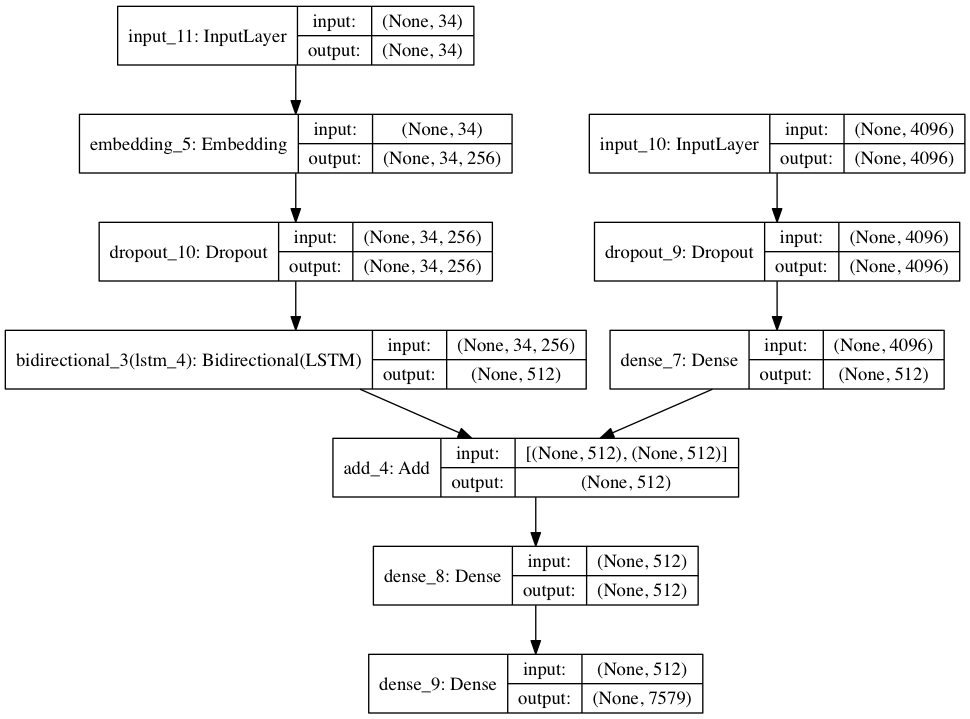

# Task MS Coco-based Neural Image Caption Generation Model

NOTE: This is an optional exercise. This MS Coco task could be completed a group.

This task is based on the MS Coco caption challenge:

http://cocodataset.org/#captions-challenge2015 

The goal here is apply the Merge and Inject Image captioning archtitectures from above to the Coco Caption dataset.  

The COCO caption [evaluation server](https://competitions.codalab.org/competitions/3221) remains open. Please submit new results to compare to state-of-the-art methods using several automatic evaluation metrics. The COCO 2015 Captioning Challenge is now, however, complete. Results were presented as part of the CVPR 2015 Large-scale Scene Understanding (LSUN) workshop and are available to view on the leaderboard.



Please follow the instructions in the download, format, guidelines, upload, and [evaluation](https://github.com/tylin/coco-caption) pages. The COCO Caption Evaluation Toolkit is also available. The tooklit provides evaluation code for common metrics for caption analysis, including the BLEU, METEOR, ROUGE-L, and CIDEr metrics. Note that for the competition, instead of automated metrics, human judges will evaluate algorithm results.

Please use this section to consolidate the results of all experiments and discuss your findings and recommendations for image captioning on the MS Coco Dataset.

Please report the following table of performance statistics for each task on the train, validation and testssets. In addition provide a block diagram detailing the best architecture used for each of the three tasks in this assignment. 

With regard to a results table, for each of the tasks  please report the following:

* Hardware used
* Experiment ID
* BLEU-1, 2, 3, 4 for test set
* The duration of training in wallclock time (in seconds)
* The duration of testing in wallclock time (in seconds)
* Experiment description

Please use a logging table structure like this to keep track of your experiments and make sure to embed them in your notebook (along with a brief description and discussion that is provided outside the table!).